In [2]:
import scipy as sp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import cmocean.cm as cmo
import gsw

df = xr.open_dataset('D:/MScData/Depth_res.nc')
depth = df['Depth'].sel(X=slice(-30,6)).sel(Y=slice(65,80))
depth_notZero = depth
depth = depth.where(depth>0,np.nan)
lon = depth['XC']
lat = depth['YC']

In [3]:
path = r'D:\MScData\HistHyd_Iceland_Greenland_Seas_2015_2020.mat'

obs = sp.io.loadmat(path)
display(obs)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov  5 09:21:25 2024',
 '__version__': '1.0',
 '__globals__': [],
 'mat': array([[(array([[  4],
                [  5],
                [ 10],
                [ 15],
                [ 20],
                [ 25],
                [ 30],
                [ 35],
                [ 40],
                [ 45],
                [ 50],
                [ 55],
                [ 60],
                [ 65],
                [ 70],
                [ 75],
                [ 80],
                [ 85],
                [ 90],
                [ 95],
                [100],
                [120],
                [140],
                [160],
                [180],
                [200],
                [225],
                [250],
                [275],
                [292]], dtype=uint16), array([[2.673],
                [2.671],
                [2.709],
                [2.919],
                [3.701],
                [4.114],
      

In [ ]:
# Extract the data
data = obs['mat']

# Initialize lists to store the data
press_list = []
temp_list = []
sal_list = []
lon_list = []
lat_list = []
time_list = []
source_list = []
id_list = []

# Loop through the data and extract each field
for entry in data[0]:
    press_list.append(entry[0].flatten().tolist())
    temp_list.append(entry[1].flatten().tolist())
    sal_list.append(entry[2].flatten().tolist())
    lon_list.append(entry[3].item())
    lat_list.append(entry[4].item())
    time_list.append(entry[5].item())
    source_list.append(entry[6].item())
    id_list.append(entry[7].item())

# Convert MATLAB datenum to datetime
def matlab_datenum_to_datetime(datenum):
    return datetime.fromordinal(int(datenum)) + timedelta(days=datenum % 1) - timedelta(days=366)

time_list = [matlab_datenum_to_datetime(t) for t in time_list]
time_list = pd.to_datetime(time_list)

# Create a pandas DataFrame
df = pd.DataFrame({
    'pressure': press_list,
    'temperature': temp_list,
    'salinity': sal_list,
    'longitude': lon_list,
    'latitude': lat_list,
    'time': time_list,
    'source': source_list,
    'ID': id_list
})

# Find the maximum length of the lists in 'pressure'
max_length = max(len(lst) for lst in df['pressure'])

# Pad the shorter lists with NaN values
pressure_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['pressure']])
temperature_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['temperature']])
salinity_padded = np.array([lst + [np.nan] * (max_length - len(lst)) for lst in df['salinity']])

# Create the xarray Dataset
ds = xr.Dataset(
    {
        'pressure': (['index', 'pressure_dim'], pressure_padded),
        'temperature': (['index', 'pressure_dim'], temperature_padded),
        'salinity': (['index', 'pressure_dim'], salinity_padded),
        'longitude': ('index', df['longitude']),
        'latitude': ('index', df['latitude']),
        'time': ('index', df['time']),
        'source': ('index',df['source'])
    },
    coords={
        'index': df.index,
        'pressure_dim': np.arange(max_length)
    }
)


# Display the xarray Dataset
display(ds)
display(np.unique(ds['source'].values))



TypeError: ufunc 'z_from_p' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<xarray.Dataset>
Dimensions:       (index: 3839, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 6 7 8 9 11 12 ... 6017 6018 6019 6020 6021 6025
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 4.0 5.0 6.0 7.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 5.72 5.723 5.718 ... nan nan nan
    salinity      (index, pressure_dim) float64 35.0 35.0 35.0 ... nan nan nan
    longitude     (index) float64 -33.62 -33.59 -33.55 ... 4.914 4.963 5.0
    latitude      (index) float64 65.06 65.94 66.04 65.28 ... 74.89 76.59 76.33
    time          (index) datetime64[ns] 2017-01-20T23:48:59.999999 ... 2019-...
    source        (index) object 'Argo' 'Argo' 'Argo' ... 'Argo' 'Argo' 'Argo'

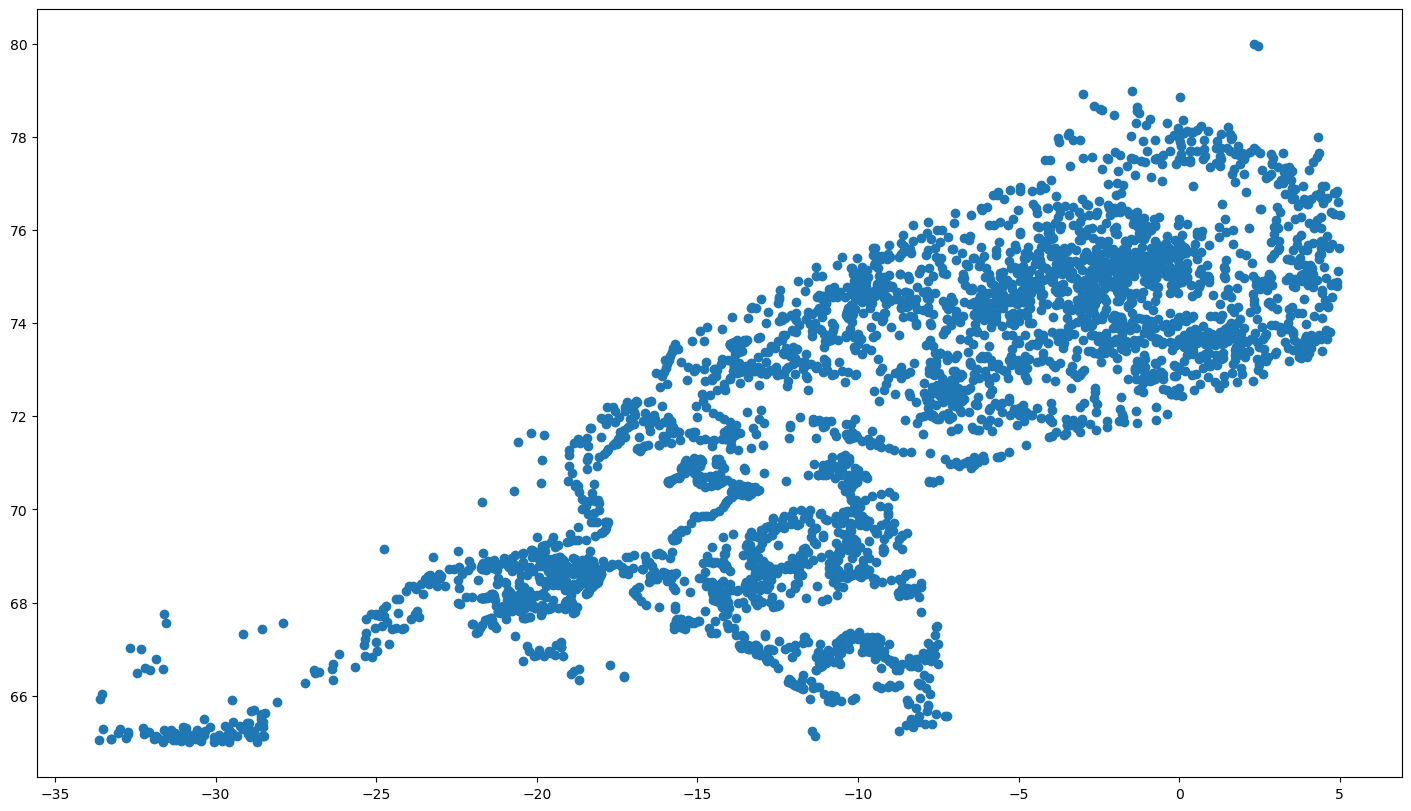

In [ ]:
cond = ds.source == 'Argo'
sour = ds.where(cond,drop=True)
display(sour)

fig, ax = plt.subplots(figsize=(14,8),layout='constrained')
ax.scatter(sour.longitude,sour.latitude)

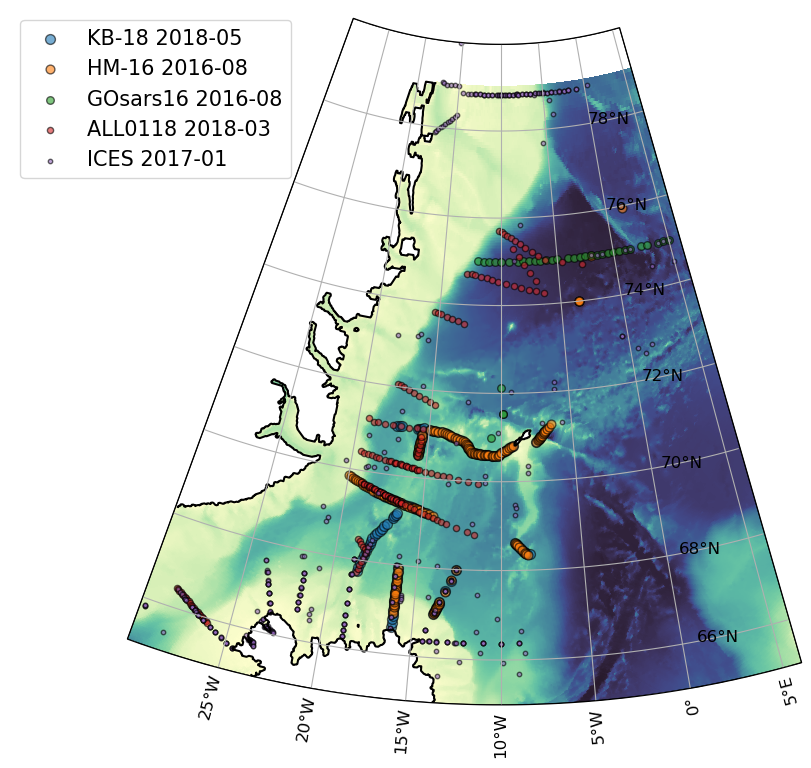

In [ ]:
source_list = ['KB-18','HM-16','GOsars16','ALL0118','ICES']
fig, ax = plt.subplots(figsize=(8,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
# Set the extent to focus on the desired geographical area
extent = [-30+10, 6+10, 65, 80]

mesh = ax.pcolormesh(lon, lat, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
ax.contour(lon,lat,depth_notZero,[0],colors='black', transform=ccrs.PlateCarree())

for x, sour in enumerate(source_list):
    cond = ds.source == sour
    sours = ds.where(cond,drop=True)
    ax.scatter(sours.longitude,sours.latitude,s=50-x*10,edgecolors='black',alpha=0.6,label=sour+f' {str(ds.where(ds.source==sour).time.mean().values)[0:7]}',transform=ccrs.PlateCarree())
    
# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax.legend(loc='upper left',prop={"size": 15})


# Fokuserer på 69-70N 18-15W

In [ ]:
cond = ((ds.longitude<-14.5) & (ds.longitude>-20)) & ((ds.latitude>69) & (ds.latitude<70))
dsf = ds.where(cond,drop=True)
ds_KB = dsf.where(dsf.source=='KB-18',drop=True)
ds_HM = dsf.where(dsf.source=='HM-16',drop=True)
# ds_GO = dsf.where(dsf.source=='GOsars16',drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)

In [ ]:
# Fine filltering data
cond = (ds_KB.latitude>69.2)
ds_KB = ds_KB.where(cond,drop=True)
# indices_to_select = list(ds_AL.index[0:3]) + list(ds_AL.index[6:8]) + list(ds_AL.index[14:16]) + list(ds_AL.index[19:21]) + list(ds_AL.index[24:26]) + list(ds_AL.index[29:35])
# cond = ds_AL.index.isin(indices_to_select)
start_date = '2018-02-13'
end_date = '2018-02-16'
cond = (ds_AL.time >= np.datetime64(start_date)) & (ds_AL.time <= np.datetime64(end_date))
ds_AL = ds_AL.where(cond, drop=True)
display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 22, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 585 622 691 718 761 ... 1064 1132 1155 1211 1241
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 -0.0831 -0.0746 ... nan nan
    salinity      (index, pressure_dim) float64 34.56 34.56 34.56 ... nan nan
    longitude     (index) float64 -19.13 -18.93 -18.74 ... -15.21 -14.9 -14.61
    latitude      (index) float64 69.74 69.71 69.7 69.67 ... 69.24 69.21 69.17
    time          (index) datetime64[ns] 2018-02-14T18:28:59.999997 ... 2018-...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

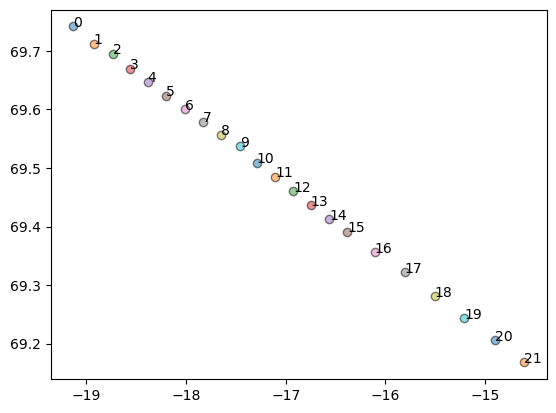

In [ ]:
# Test the transect structure
fig, ax = plt.subplots()
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5)
    ax.annotate(x,(data.longitude[x],data.latitude[x]))

In [ ]:
import gsw

# KB
num = np.arange(len(ds_KB.index))
dist_KB = [gsw.distance(lon=np.array([ds_KB.longitude[0],ds_KB.longitude[num[x]]]),lat=np.array([ds_KB.latitude[0],ds_KB.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_KB.salinity[x],p=ds_KB.pressure[x],lon=ds_KB.longitude[x],lat=ds_KB.latitude[x]) for x in num]
ds_KB['SA'] = (('index','pressure_dim'),SA)

# HM
num = np.arange(len(ds_HM.index))
dist_HM = [gsw.distance(lon=np.array([ds_HM.longitude[0],ds_HM.longitude[num[x]]]),lat=np.array([ds_HM.latitude[0],ds_HM.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_HM.salinity[x],p=ds_HM.pressure[x],lon=ds_HM.longitude[x],lat=ds_HM.latitude[x]) for x in num]
ds_HM['SA'] = (('index','pressure_dim'),SA)

# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_69.nc')

Text(0, 0.5, 'Depth [-dbar]')

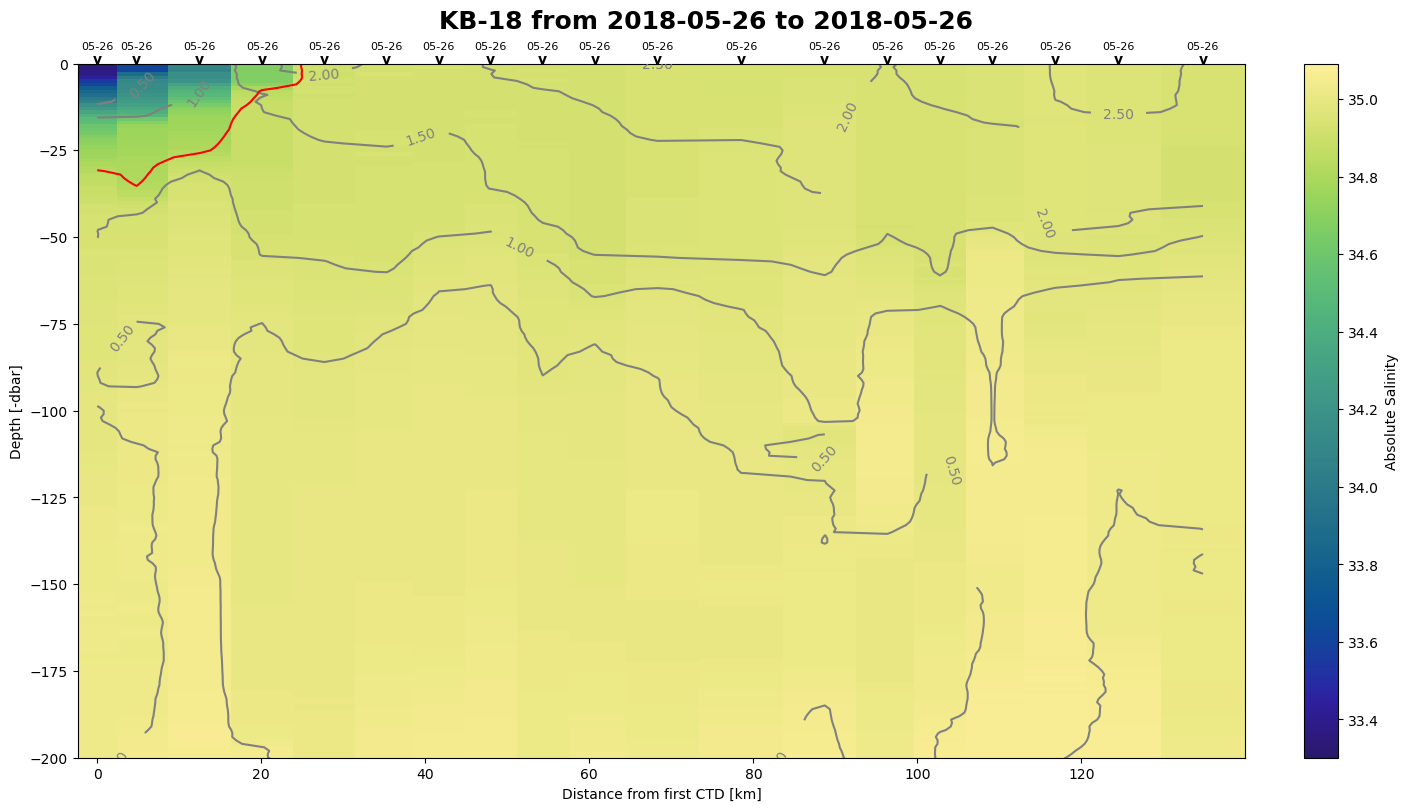

In [ ]:
# Create a 2D meshgrid for dist_KB and pressure
dist_KB_2d, pressure_2d = np.meshgrid(dist_KB, ds_KB.pressure_dim)

fig, ax = plt.subplots(figsize=(14,8),layout='constrained')
mesh = ax.pcolormesh(dist_KB_2d,-pressure_2d,ds_KB.SA.T,cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')

cntr = ax.contour(dist_KB_2d, -pressure_2d, ds_KB.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_KB_2d,-pressure_2d,ds_KB.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_KB.time.values):
    ax.text(dist_KB[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_KB[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-200,0)
fig.suptitle(f'{ds_KB.source[0].values} from {str(ds_KB.time[0].values)[0:10]} to {str(ds_KB.time[-1].values)[0:10]}',fontsize=18,fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

Text(0, 0.5, 'Depth [-dbar]')

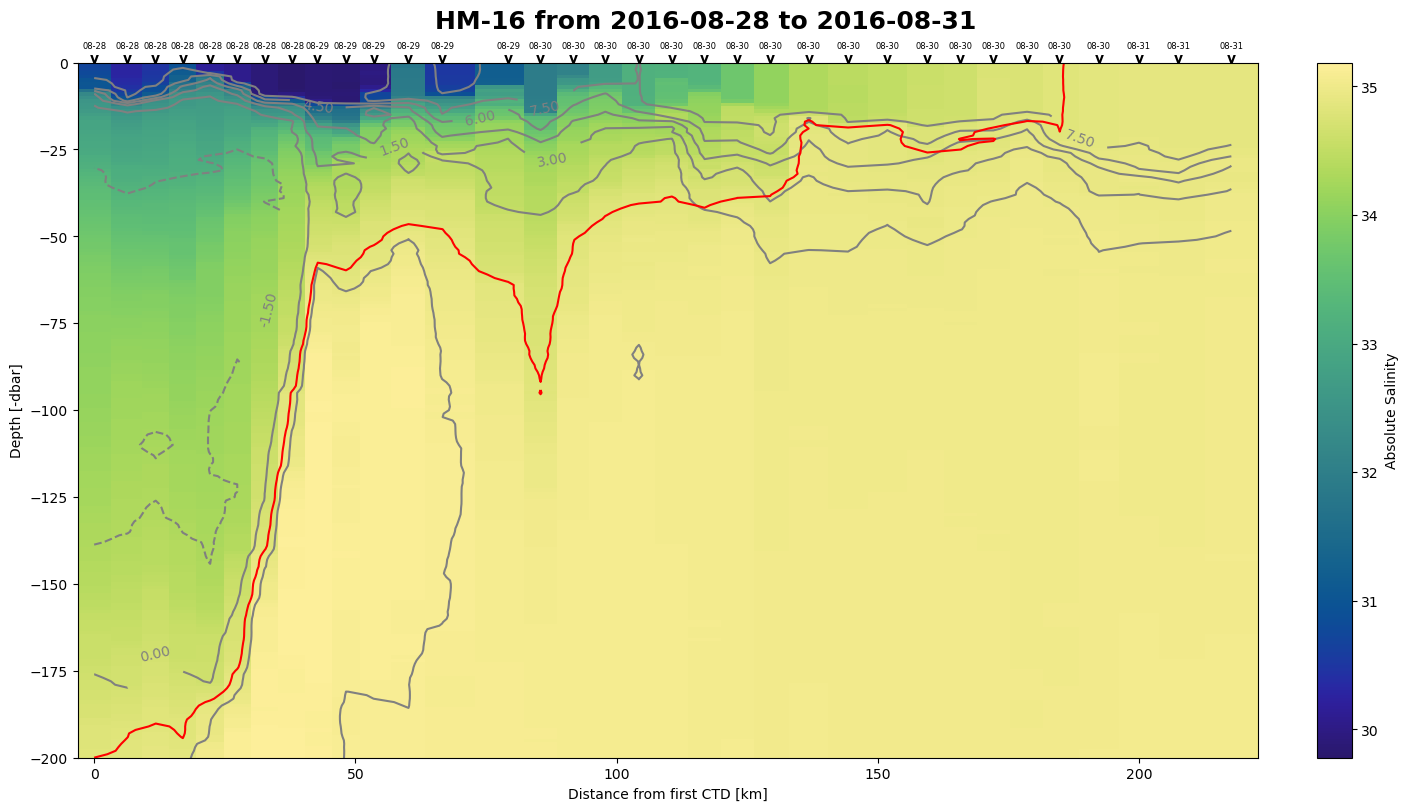

In [ ]:
# Create a 2D meshgrid for dist_KB and pressure
dist_HM_2d, pressure_2d = np.meshgrid(dist_HM, ds_HM.pressure_dim)

fig, ax = plt.subplots(figsize=(14,8),layout='constrained')
mesh = ax.pcolormesh(dist_HM_2d,-pressure_2d,ds_HM.SA.T,cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')

cntr = ax.contour(dist_HM_2d, -pressure_2d, ds_HM.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_HM_2d,-pressure_2d,ds_HM.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_HM.time.values):
    ax.text(dist_HM[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_HM[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=6)

ax.set_ylim(-200,0)
fig.suptitle(f'{ds_HM.source[0].values} from {str(ds_HM.time[0].values)[0:10]} to {str(ds_HM.time[-1].values)[0:10]}',fontsize=18,fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

Text(0, 0.5, 'Depth [-dbar]')

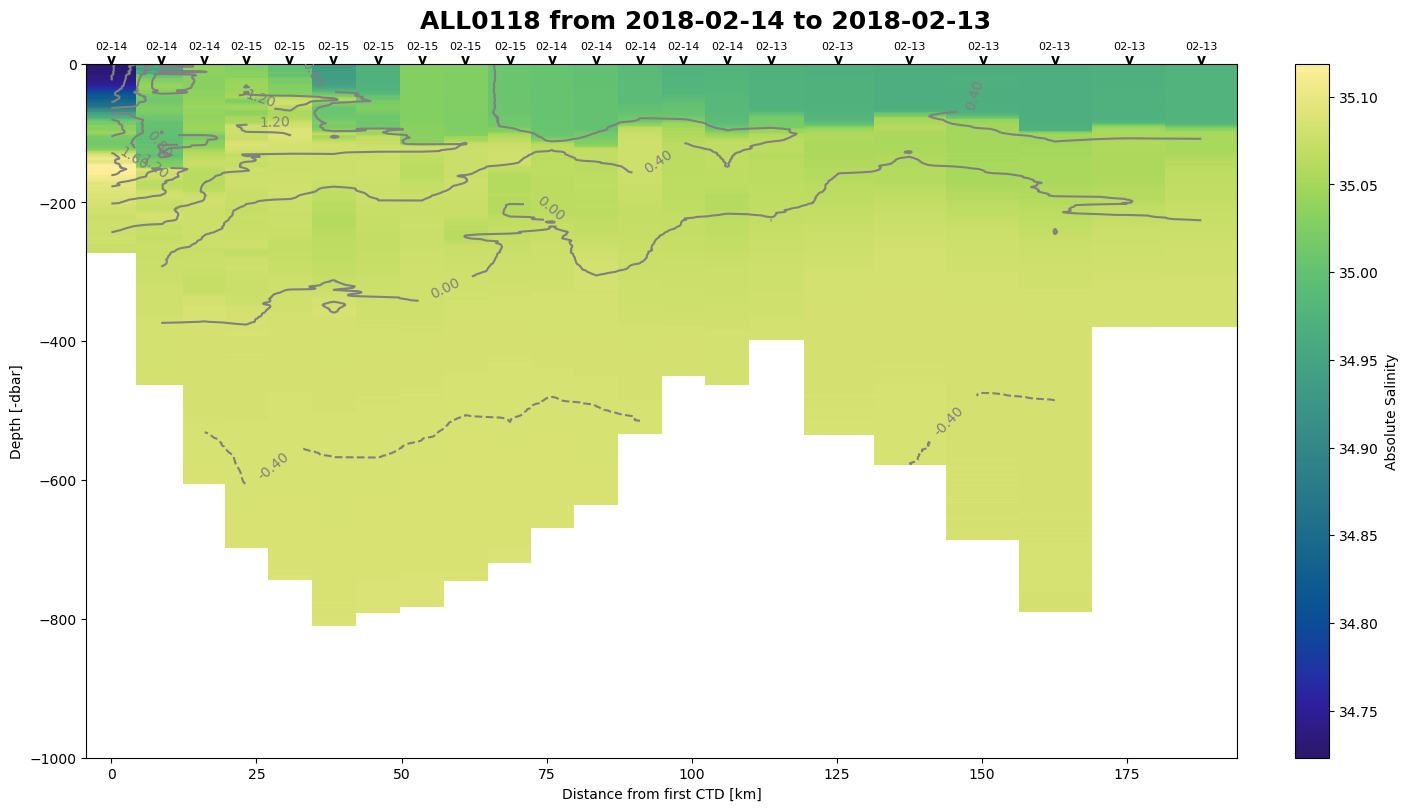

In [ ]:
# Assuming ds_AL is your dataset and it has dist_AL, pressure_dim, SA, and temperature attributes
# Create a 2D meshgrid for dist_AL and pressure
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-1000, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

# Overview of profile locations

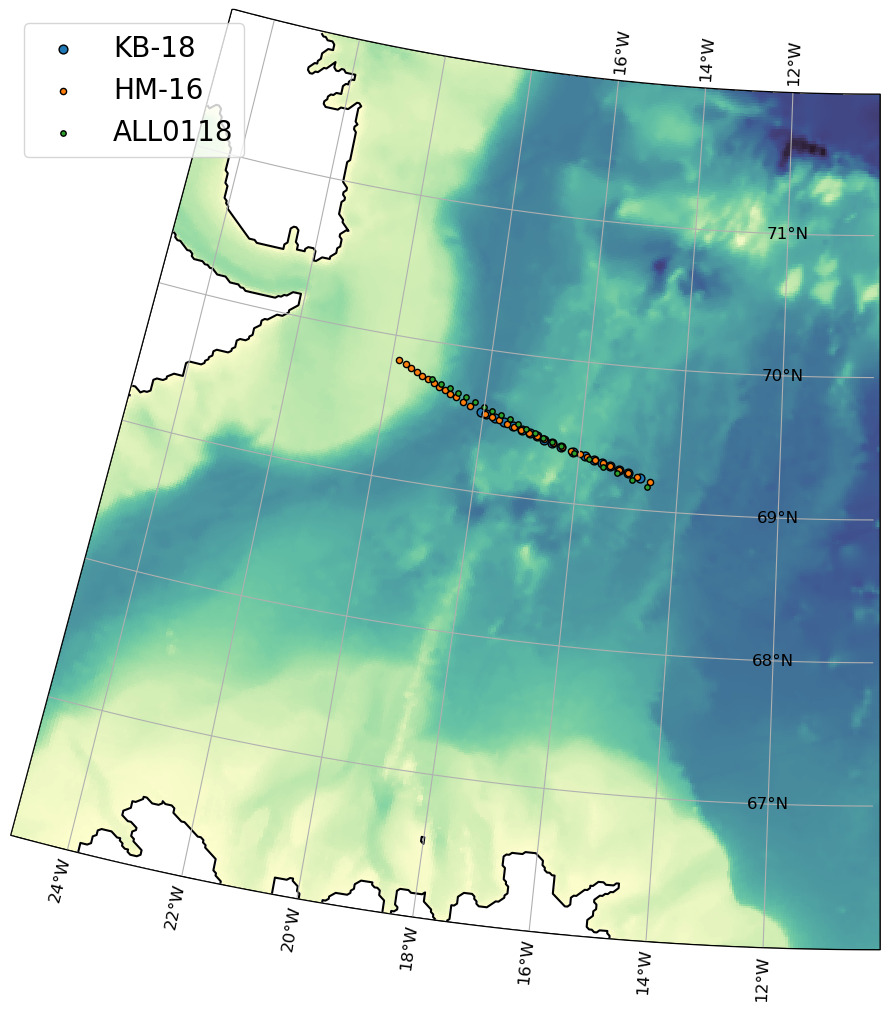

In [ ]:
depth = depth.sel(X=slice(-25,-10)).sel(Y=slice(66,72))
depth_notZero = depth_notZero.sel(X=slice(-25,-10)).sel(Y=slice(66,72))
lon = depth['XC']
lat = depth['YC']
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))

# Set the extent to focus on the desired geographical area
extent = [-25+10, -10+10, 66, 72]

mesh = ax.pcolormesh(lon, lat, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
ax.contour(lon,lat,depth_notZero,[0],colors='black', transform=ccrs.PlateCarree())

ax.scatter(ds_KB.longitude,ds_KB.latitude,s=40,edgecolor='black',label='KB-18',transform=ccrs.PlateCarree())
ax.scatter(ds_HM.longitude,ds_HM.latitude,s=20,edgecolor='black',label='HM-16',transform=ccrs.PlateCarree())
ax.scatter(ds_AL.longitude,ds_AL.latitude,s=15,edgecolor='black',label='ALL0118',transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax.legend(loc='upper left',prop={"size": 20})


# 73-74N

In [ ]:
cond = ((ds.longitude<-12) & (ds.longitude>-17)) & ((ds.latitude>73) & (ds.latitude<74))
dsf = ds.where(cond,drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)
display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 7, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 1144 1164 1219 1279 1372 1481 1588
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 -0.4026 -0.3857 ... nan nan
    salinity      (index, pressure_dim) float64 34.57 34.57 34.57 ... nan nan
    longitude     (index) float64 -15.4 -15.13 -14.84 -14.38 -13.93 -13.48 -13.0
    latitude      (index) float64 73.77 73.78 73.75 73.7 73.66 73.61 73.57
    time          (index) datetime64[ns] 2018-03-12T11:54:00.000001 ... 2018-...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

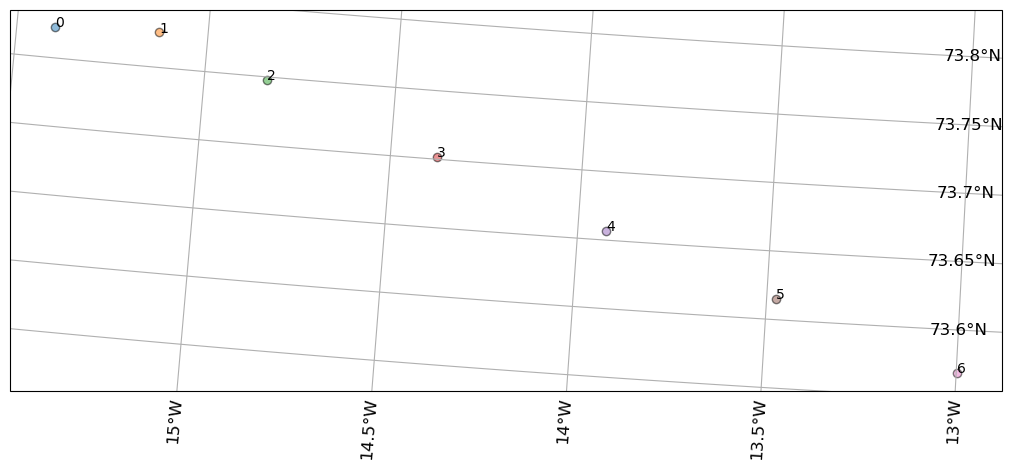

In [ ]:
# Test the transect structure
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5,transform=ccrs.PlateCarree())
    ax.annotate(x,(data.longitude[x],data.latitude[x]),transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

In [ ]:
# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_735.nc')

Text(0, 0.5, 'Depth [-dbar]')

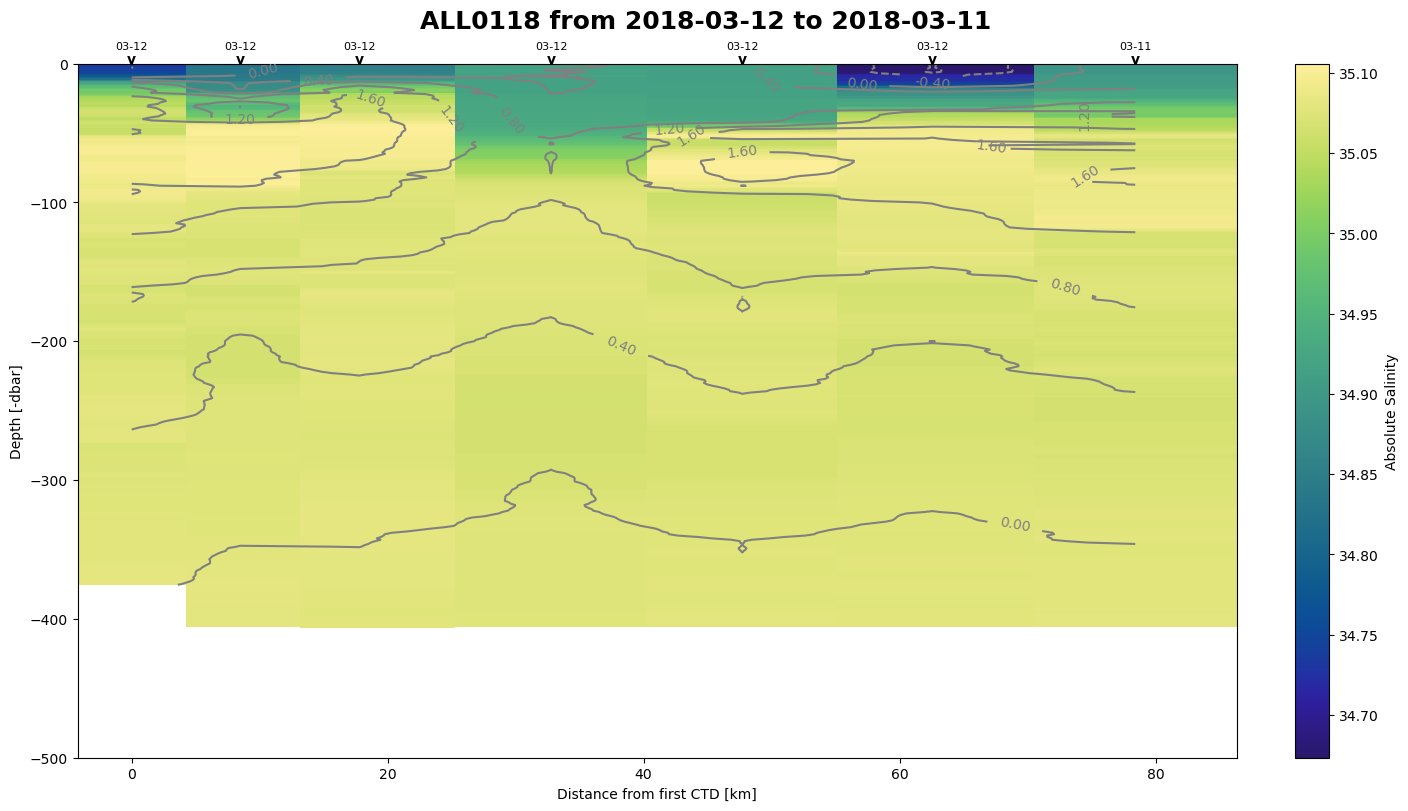

In [ ]:
# Assuming ds_AL is your dataset and it has dist_AL, pressure_dim, SA, and temperature attributes
# Create a 2D meshgrid for dist_AL and pressure
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-500, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

# Around 70N

In [ ]:
cond = ((ds.longitude<-8) & (ds.longitude>-22)) & ((ds.latitude>69.8) & (ds.latitude<70.2))
dsf = ds.where(cond,drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)
start_date = '2018-02-17'
end_date = '2018-02-19'
cond = (ds_AL.time >= np.datetime64(start_date)) & (ds_AL.time <= np.datetime64(end_date))
ds_AL = ds_AL.where(cond, drop=True)
display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 9, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 1142 1182 1240 1313 1392 1485 1632 1723 1818
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 0.5698 0.5652 0.5639 ... nan nan
    salinity      (index, pressure_dim) float64 34.82 34.82 34.82 ... nan nan
    longitude     (index) float64 -15.42 -15.03 -14.64 ... -12.81 -12.17 -11.52
    latitude      (index) float64 70.18 70.16 70.13 70.11 ... 70.02 69.98 69.95
    time          (index) datetime64[ns] 2018-02-17T22:43:00.000004 ... 2018-...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

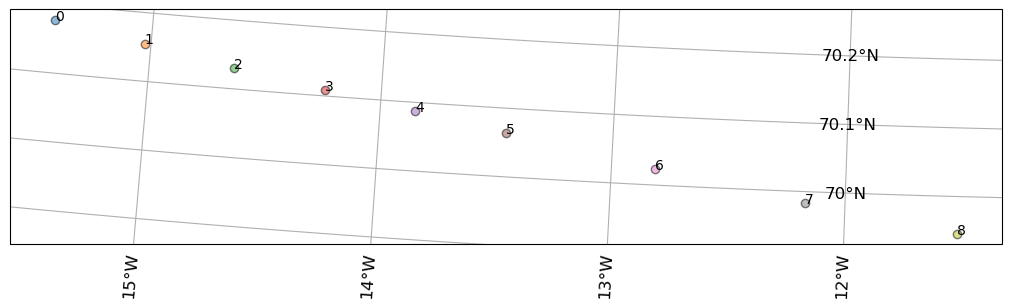

In [ ]:
# Test the transect structure
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5,transform=ccrs.PlateCarree())
    ax.annotate(x,(data.longitude[x],data.latitude[x]),transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

In [ ]:
# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_70.nc')

Text(0, 0.5, 'Depth [-dbar]')

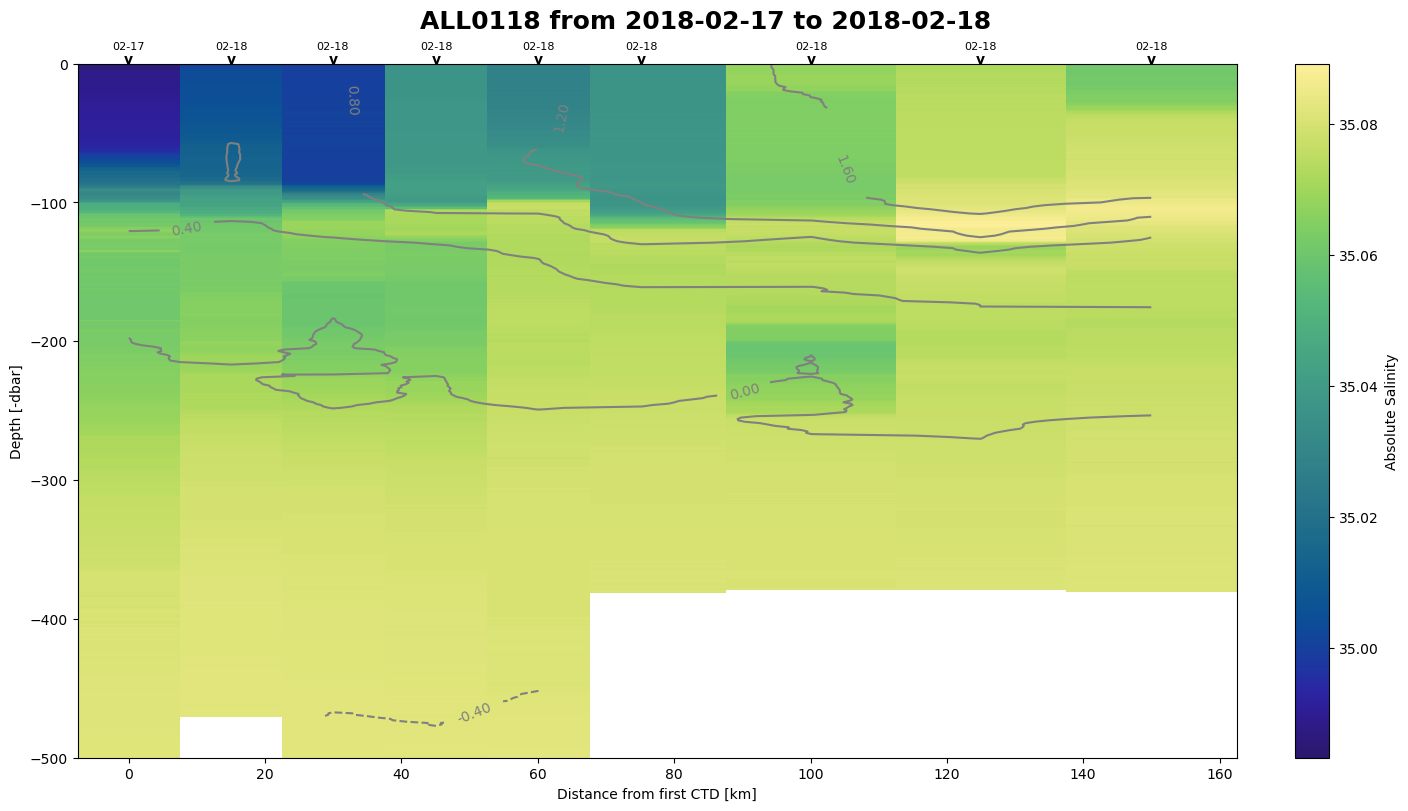

In [ ]:
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_AL_2d,-pressure_2d,ds_AL.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-500, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

# Around 71N

In [ ]:
cond = ((ds.longitude<-13) & (ds.longitude>-20)) & ((ds.latitude>71) & (ds.latitude<71.5))
dsf = ds.where(cond,drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)
display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 9, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 553 621 702 799 850 895 942 1053 1141
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 -1.719 -1.72 -1.719 ... nan nan
    salinity      (index, pressure_dim) float64 33.78 33.78 33.78 ... nan nan
    longitude     (index) float64 -19.3 -18.93 -18.66 ... -16.43 -15.86 -15.45
    latitude      (index) float64 71.19 71.13 71.13 71.12 ... 71.11 71.11 71.1
    time          (index) datetime64[ns] 2018-02-20T12:00:00 ... 2018-02-19T1...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

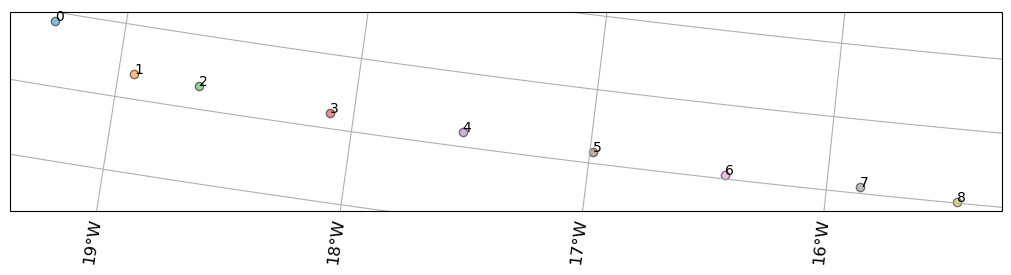

In [ ]:
# Test the transect structure
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5,transform=ccrs.PlateCarree())
    ax.annotate(x,(data.longitude[x],data.latitude[x]),transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

In [ ]:
# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_71.nc')

Text(0, 0.5, 'Depth [-dbar]')

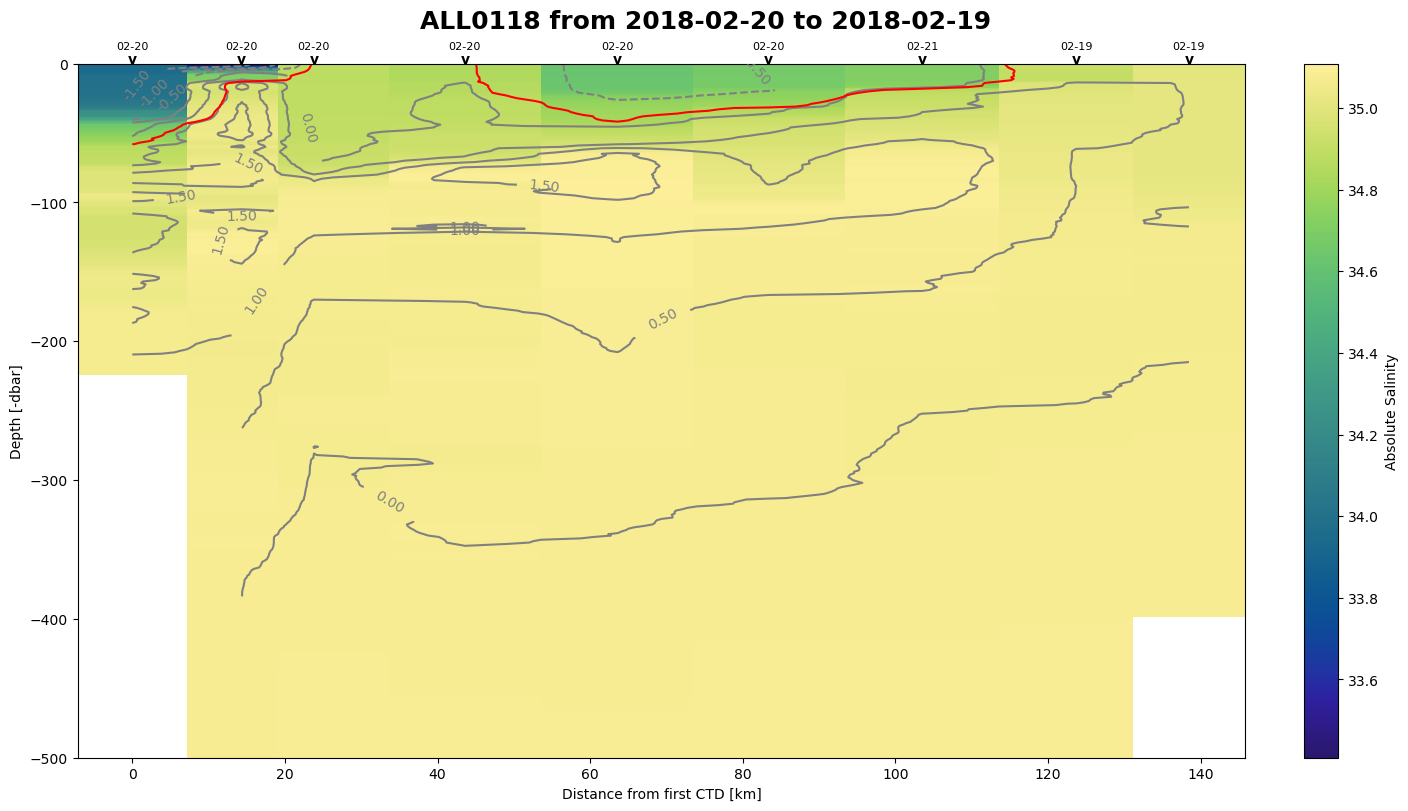

In [ ]:
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_AL_2d,-pressure_2d,ds_AL.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-500, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

# Around 72N

In [ ]:
cond = ((ds.longitude<-13) & (ds.longitude>-20)) & ((ds.latitude>71.4) & (ds.latitude<72.5))
dsf = ds.where(cond,drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)
display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 9, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 848 865 880 920 954 1043 1124 1165 1234
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 -0.7432 -0.7443 ... nan nan
    salinity      (index, pressure_dim) float64 34.42 34.42 34.42 ... nan nan
    longitude     (index) float64 -17.55 -17.38 -17.13 ... -15.53 -15.13 -14.73
    latitude      (index) float64 72.05 72.04 72.01 71.95 ... 71.79 71.74 71.69
    time          (index) datetime64[ns] 2018-03-18T11:09:59.999998 ... 2018-...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

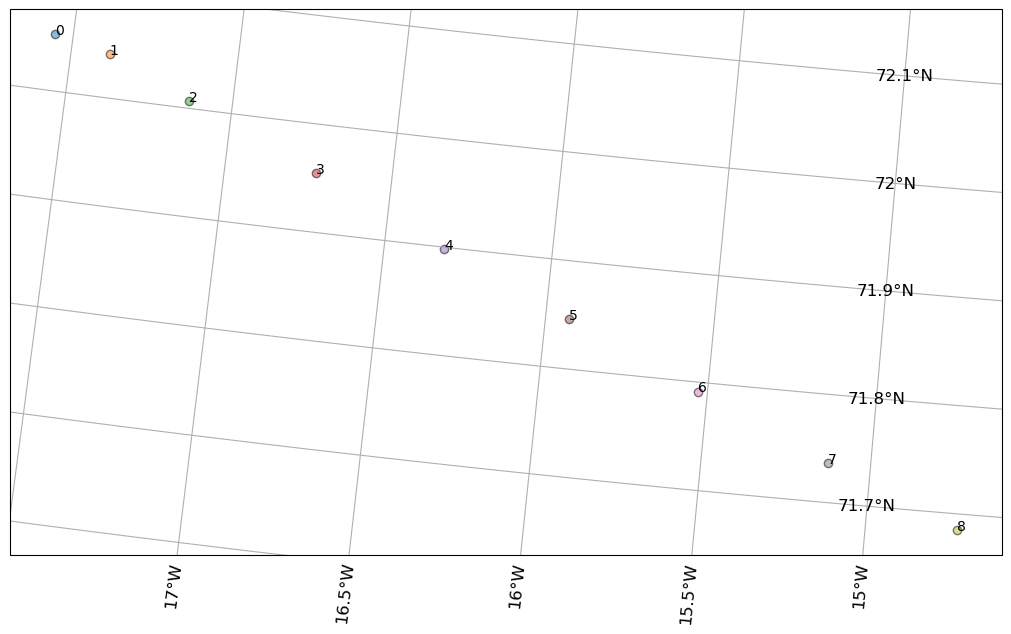

In [ ]:
# Test the transect structure
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5,transform=ccrs.PlateCarree())
    ax.annotate(x,(data.longitude[x],data.latitude[x]),transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

In [ ]:
# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_72.nc')

Text(0, 0.5, 'Depth [-dbar]')

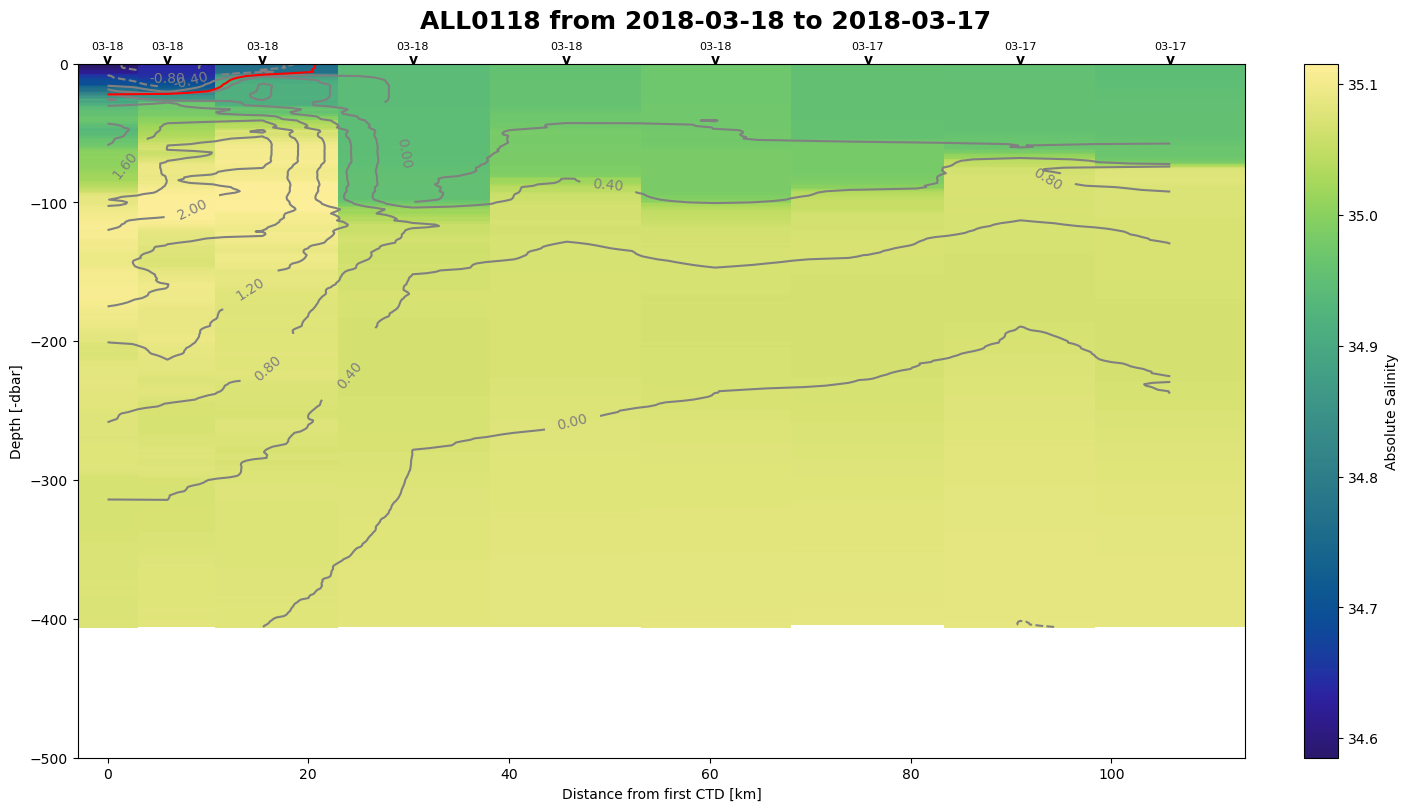

In [ ]:
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_AL_2d,-pressure_2d,ds_AL.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-500, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')

# Around 75N

In [ ]:
cond = ((ds.longitude<0) & (ds.longitude>-11)) & ((ds.latitude>74.4) & (ds.latitude<76))
dsf = ds.where(cond,drop=True)
ds_AL = dsf.where(dsf.source=='ALL0118',drop=True)

start_date = '2018-03-13'
end_date = '2018-03-15'
cond = (ds_AL.time >= np.datetime64(start_date)) & (ds_AL.time <= np.datetime64(end_date))
ds_AL = ds_AL.where(cond, drop=True)

display(ds_AL)

<xarray.Dataset>
Dimensions:       (index: 13, pressure_dim: 3790)
Coordinates:
  * index         (index) int64 2100 2166 2221 2301 2382 ... 2713 2777 2929 3120
  * pressure_dim  (pressure_dim) int32 0 1 2 3 4 5 ... 3785 3786 3787 3788 3789
Data variables:
    pressure      (index, pressure_dim) float64 2.0 4.0 6.0 8.0 ... nan nan nan
    temperature   (index, pressure_dim) float64 -0.7405 -0.7408 ... nan nan
    salinity      (index, pressure_dim) float64 34.4 34.4 34.4 ... nan nan nan
    longitude     (index) float64 -10.15 -9.906 -9.715 ... -6.055 -4.592 -2.897
    latitude      (index) float64 75.72 75.68 75.63 75.59 ... 75.01 74.92 74.82
    time          (index) datetime64[ns] 2018-03-14T14:17:59.999999 ... 2018-...
    source        (index) object 'ALL0118' 'ALL0118' ... 'ALL0118' 'ALL0118'

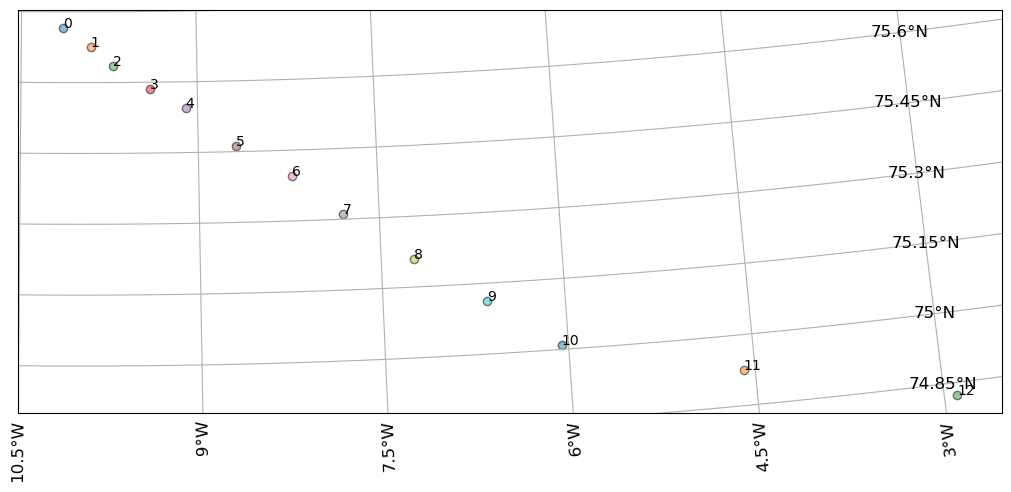

In [ ]:
# Test the transect structure
fig, ax = plt.subplots(figsize=(10,10),layout='constrained',subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)))
data = ds_AL
for x,i in enumerate(data.index):
    ax.scatter(data.longitude[x],data.latitude[x], edgecolors='black',alpha=0.5,transform=ccrs.PlateCarree())
    ax.annotate(x,(data.longitude[x],data.latitude[x]),transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

In [ ]:
# AL
num = np.arange(len(ds_AL.index))
dist_AL = [gsw.distance(lon=np.array([ds_AL.longitude[0],ds_AL.longitude[num[x]]]),lat=np.array([ds_AL.latitude[0],ds_AL.latitude[num[x]]]))/1000 for x in num]
SA = [gsw.SA_from_SP(SP=ds_AL.salinity[x],p=ds_AL.pressure[x],lon=ds_AL.longitude[x],lat=ds_AL.latitude[x]) for x in num]
ds_AL['SA'] = (('index','pressure_dim'),SA)
ds_AL.to_netcdf(r'D:\MScData\AL_75.nc')

Text(0, 0.5, 'Depth [-dbar]')

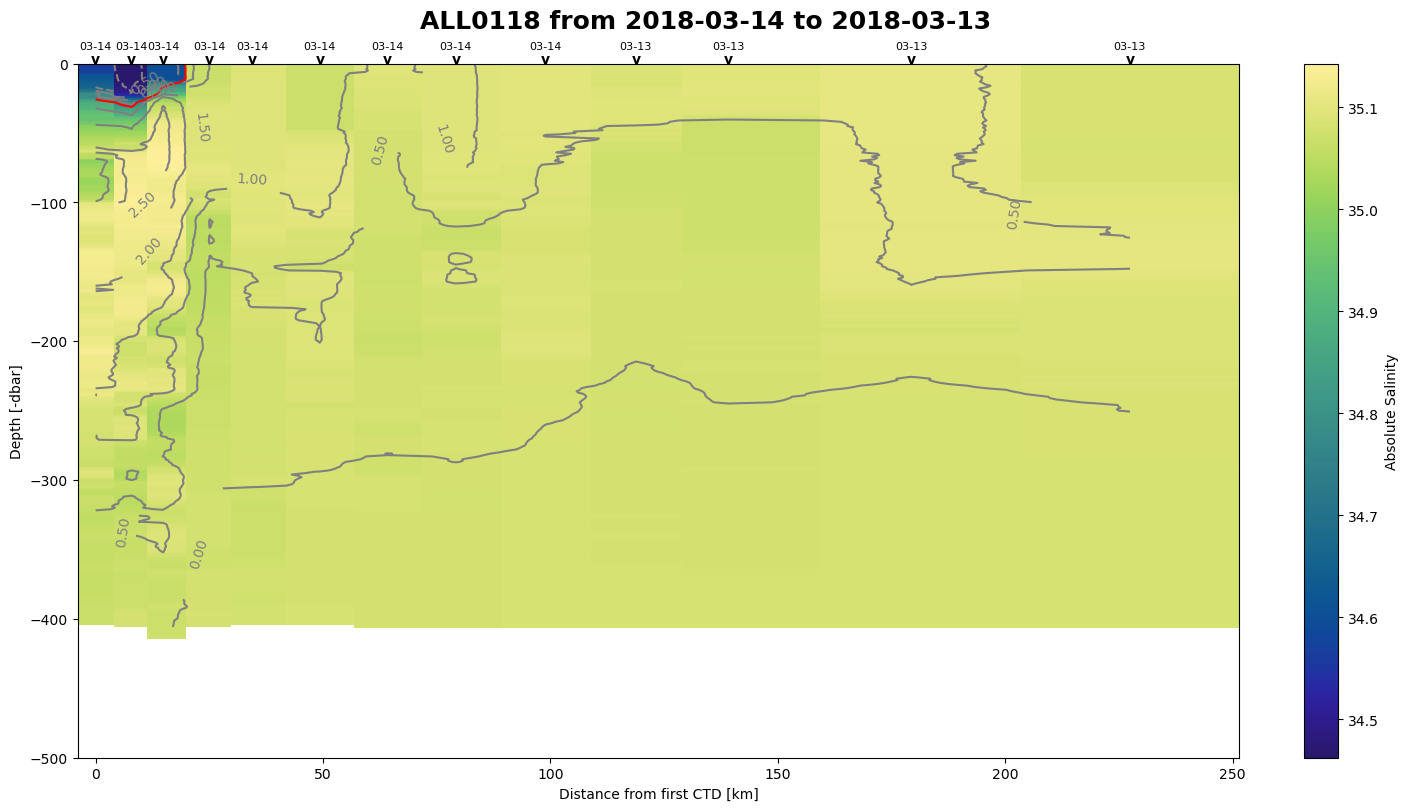

In [ ]:
dist_AL_2d, pressure_2d = np.meshgrid(dist_AL, ds_AL.pressure_dim)

fig, ax = plt.subplots(figsize=(14, 8), layout='constrained')
mesh = ax.pcolormesh(dist_AL_2d, -pressure_2d, ds_AL.SA.T, cmap=cmo.haline)
cbar = fig.colorbar(mesh)
cbar.set_label('Absolute Salinity')


cntr = ax.contour(dist_AL_2d, -pressure_2d, ds_AL.temperature.T, colors='grey')
ax.clabel(cntr, fmt="%2.2f", use_clabeltext=True)

ax.contour(dist_AL_2d,-pressure_2d,ds_AL.salinity.T,[34.66],colors='red')

for x,time in enumerate(ds_AL.time.values):
    ax.text(dist_AL[x],0,'v',ha='center',fontweight='bold')
    ax.annotate(str(time)[5:10],(dist_AL[x],0),xytext=(0,10),textcoords='offset points',ha='center',fontsize=8)

ax.set_ylim(-500, 0)
fig.suptitle(f'{ds_AL.source[0].values} from {str(ds_AL.time[0].values)[0:10]} to {str(ds_AL.time[-1].values)[0:10]}', fontsize=18, fontweight='bold')
ax.set_xlabel('Distance from first CTD [km]')
ax.set_ylabel('Depth [-dbar]')